In [1]:
# Import và Kiểm tra phần cứng
import torch
import os
from ultralytics import YOLO

from IPython.display import clear_output
clear_output()

print(f"PyTorch Version: {torch.__version__}")

if torch.cuda.is_available():
    print(f"Đã kết nối GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Đang chạy bằng CPU. Hãy kiểm tra lại Driver NVIDIA.")

PyTorch Version: 2.8.0+cu126
Đã kết nối GPU: NVIDIA GeForce GTX 1660 Ti


Đã tìm thấy model: best.pt
2. Đang kiểm tra folder: datasets/waste_cls/test
   Tìm thấy các lớp: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
   Tổng số ảnh tìm thấy: 2025
3. Đang chạy dự đoán (Vui lòng chờ)...

Tốc độ trung bình: 44.44 FPS (22.50 ms/ảnh)

4. Đang vẽ biểu đồ ...

=== BÁO CÁO KẾT QUẢ ===
              precision    recall  f1-score   support

     battery       0.98      0.99      0.98        95
  biological       1.00      0.98      0.99       100
   cardboard       0.97      0.99      0.98       186
     clothes       0.99      1.00      0.99       533
       glass       0.99      0.99      0.99       320
       metal       0.94      0.95      0.94       108
       paper       0.98      0.94      0.96       179
     plastic       0.98      0.94      0.96       210
       shoes       0.98      0.99      0.99       198
       trash       0.92      0.94      0.93        96

    accuracy                          

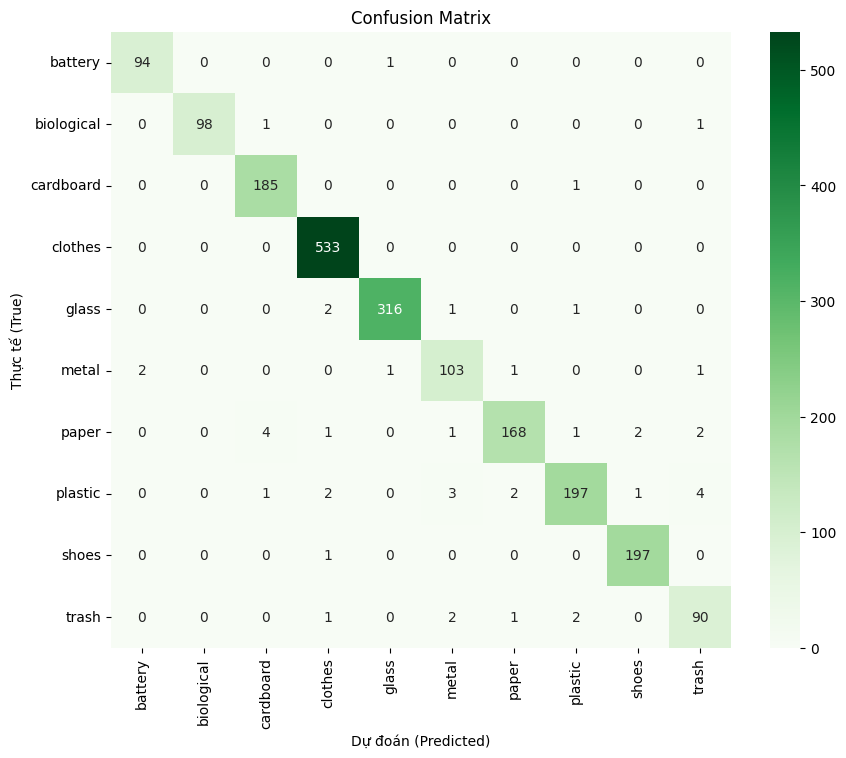

In [2]:
from ultralytics import YOLO
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import time

# --- BƯỚC 1: TÌM FILE MODEL ---

found_files = glob.glob('best.pt', recursive=True)

if not found_files:
    print("Lỗi: Không tìm thấy file 'best.pt' nào. Hãy kiểm tra lại việc train.")
else:
    model_path = found_files[-1]
    print(f"Đã tìm thấy model: {model_path}")
    
    # Load model
    model = YOLO('best.pt')
    test_dir = 'datasets/waste_cls/test'

    # --- BƯỚC 2: KIỂM TRA DỮ LIỆU ---
    print(f"2. Đang kiểm tra folder: {test_dir}")
    
    if not os.path.exists(test_dir):
        print(f"Lỗi: Đường dẫn {test_dir} không tồn tại!")
    else:
        # Lấy danh sách ảnh và nhãn
        image_paths = []
        y_true = []
        class_names = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
        
        print(f"   Tìm thấy các lớp: {class_names}")

        for label in class_names:
            folder_path = os.path.join(test_dir, label)
            # Tìm cả đuôi hoa và thường
            for ext in ('*.png', '*.jpg', '*.jpeg'):
                for img_file in glob.glob(os.path.join(folder_path, ext)):
                    image_paths.append(img_file)
                    y_true.append(label)
        
        print(f"   Tổng số ảnh tìm thấy: {len(image_paths)}")

        if len(image_paths) == 0:
            print("Không có ảnh nào để test. Code sẽ dừng tại đây.")
        else:
            # --- BƯỚC 3: DỰ ĐOÁN ---
            print("3. Đang chạy dự đoán (Vui lòng chờ)...")
            
            y_pred = []
            inference_times = []
            for img_path in image_paths:
                t0 = time.time()
                # Dự đoán
                results = model(img_path, verbose=False)
                
                t1 = time.time()
                inference_times.append((t1 - t0) * 1000)
                
                # Lấy kết quả
                pred_idx = results[0].probs.top1
                y_pred.append(results[0].names[pred_idx])
                
            # Tính FPS
            avg_latency = np.mean(inference_times)
            fps = 1000 / avg_latency
            print(f"\nTốc độ trung bình: {fps:.2f} FPS ({avg_latency:.2f} ms/ảnh)")

            # --- BƯỚC 4: VẼ BIỂU ĐỒ ---
            print("\n4. Đang vẽ biểu đồ ...")
            
            try:
                # In báo cáo dạng chữ
                print("\n=== BÁO CÁO KẾT QUẢ ===")
                print(classification_report(y_true, y_pred, target_names=class_names))

                # Vẽ ma trận
                cm = confusion_matrix(y_true, y_pred, labels=class_names)
                
                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                            xticklabels=class_names, yticklabels=class_names)
                plt.xlabel('Dự đoán (Predicted)')
                plt.ylabel('Thực tế (True)')
                plt.title('Confusion Matrix')
                
                print("Đang hiển thị ảnh...")
                plt.show()
                
            except Exception as e:
                print(f"Lỗi khi vẽ biểu đồ: {e}")

In [3]:
import cv2
import glob
from ultralytics import YOLO

# --- BƯỚC 1: TỰ ĐỘNG TÌM MODEL ---
found_files = glob.glob('best.pt', recursive=True)
if not found_files:
    print("Lỗi: Không tìm thấy file 'best.pt'.")
    model_path = None
else:
    model_path = found_files[-1]
    print(f"Đã nạp model từ: {model_path}")

# --- BƯỚC 2: MỞ CAMERA VÀ NHẬN DIỆN ---
if model_path:
    model = YOLO(model_path)
    cap = cv2.VideoCapture(0)
    
    # Cài đặt độ phân giải để cam ổn định hơn (Tùy chọn)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

    if not cap.isOpened():
        print("Lỗi: Không thể mở Camera.")
    else:
        print("Camera đã bật! Bấm 'q' để thoát.")
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        try:  # Bắt đầu khối an toàn
            while True:
                ret, frame = cap.read()
                if not ret:
                    print("Mất tín hiệu camera.")
                    break
                
                # --- Phần xử lý AI  ---
                results = model(frame, verbose=False)
                top1_index = results[0].probs.top1
                conf = results[0].probs.top1conf.item()
                label = results[0].names[top1_index]
                
                text = f"{label.upper()}: {conf:.1%}"
                color = (0, 255, 0) if conf > 0.7 else (0, 0, 255)
                
                cv2.rectangle(frame, (10, 10), (300, 60), (0, 0, 0), -1) 
                cv2.putText(frame, text, (20, 45), font, 1, color, 2, cv2.LINE_AA)
                
                cv2.imshow('YOLOv12 Waste Classification', frame)
                
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                    
        except Exception as e:
            print(f"Có lỗi xảy ra: {e}")
            
        finally:
            # Luôn luôn giải phóng camera dù có lỗi hay không
            print("Đang giải phóng camera...")
            cap.release()
            cv2.destroyAllWindows()
            print("Đã tắt Camera an toàn.")

Đã nạp model từ: best.pt
Camera đã bật! Bấm 'q' để thoát.
Mất tín hiệu camera.
Đang giải phóng camera...
Đã tắt Camera an toàn.


In [4]:
import ipywidgets as widgets
from IPython.display import display, clear_output, Image
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import io

# --- 1. NẠP MODEL ---
print("Đang tải model...", end="\r")
found_files = glob.glob('best.pt', recursive=True)
model = None

if not found_files:
    print("Lỗi: Không tìm thấy file 'best.pt'.")
else:
    model_path = found_files[-1]
    model = YOLO(model_path)
    print(f"Đã nạp model: {os.path.basename(model_path)}")

# --- 2. TẠO NÚT UPLOAD (Code mới) ---
uploader = widgets.FileUpload(
    accept='image/*', 
    multiple=False, 
    description='Tải ảnh lên',
    button_style='success' # Màu xanh
)

output = widgets.Output() # Vùng hiển thị kết quả

def on_upload_change(change):
    # Nếu không có file mới thì thoát
    if not change['new'] or not model:
        return

    with output:
        clear_output(wait=True)
        try:
            print("Đang nhận file...")
            
            # --- XỬ LÝ DỮ LIỆU (Tương thích ipywidgets 8.0+) ---
            # Lấy file đầu tiên trong danh sách tải lên
            uploaded_file = change['new'][0] 
            
            # Lấy nội dung binary
            content = uploaded_file['content']
            
            # Lấy tên file
            fname = uploaded_file['name']
            
            # Lưu thành file tạm (quan trọng để YOLO đọc được)
            temp_path = "temp_upload_img.jpg"
            with open(temp_path, "wb") as f:
                f.write(content)
            
            print(f"Đang dự đoán: {fname}...")

            # --- DỰ ĐOÁN ---
            results = model(temp_path, verbose=False)
            
            # Lấy thông số
            top1 = results[0].probs.top1
            label = results[0].names[top1]
            conf = results[0].probs.top1conf.item()

            # --- VẼ HÌNH ---
            img = mpimg.imread(temp_path)
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.axis('off')
            
            title = f"{label.upper()} ({conf:.1%})"
            color = 'green' if conf > 0.7 else 'red'
            plt.title(title, color=color, fontsize=14, fontweight='bold')
            plt.show()

            # Reset nút upload để dùng lại
            uploader.value = () 

        except Exception as e:
            print(f"\nCÓ LỖI XẢY RA: {e}")

# Gán hàm vào sự kiện
uploader.observe(on_upload_change, names='value')

# Hiển thị
display(widgets.VBox([uploader, output]))

Đã nạp model: best.pt
